In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt 
from datetime import timedelta as delta
import statsmodels.api as sm
from scipy import stats, interpolate
from shapely.geometry import shape
from functools import reduce
import json

In [39]:
def preprocess(data, 
               train=True,   
               rename=False, 
               expand_dates=False,
               interpolate_ts=False,
               scaling=False, 
               boxcox=False, 
               diff=False):
    
    def parse_json(obj):
        coords = shape(json.loads(obj.values[0])).bounds
        x = (coords[0] + coords[2]) / 2
        y = (coords[1] + coords[3]) / 2
        return (x, y)
    
    def interpolate_(row):
        nans = row.isna()
        not_nans = np.logical_not(nans)
        
        index = np.int_(row.index)
        values = np.float_(row.values)
        
        xs = index[not_nans]
        ys = values[not_nans]
        
        func = interpolate.Akima1DInterpolator(xs, ys)
        row[nans] = func(index[nans])
        
        return row
    
    def fill_fl_nan(row):
        not_nans = np.where(np.logical_not(row.isna()))[0]
        if not_nans[0] > 0:
            row.iloc[0] = row.iloc[not_nans[0]]
        if not_nans[-1] < row.shape[0]:
            row.iloc[-1] = row.iloc[not_nans[-1]]

        return row

    global ts_cols
    
    if train:
        target = data[target_col]
        features = data.drop(target_col.to_list(), axis=1)
    else:
        target = None
        features = data
    
    if rename:
        start = dt.strptime("2021-04-15", "%Y-%m-%d")

        new_names = {old_name: (dt.strptime(old_name.split('_')[-1], "%Y-%m-%d") - start).days+1 for old_name in ts_cols}
        features = features.rename(new_names, axis=1)

        ts_cols = features.columns.difference(area_col.append([geo_col, target_col])).to_list()

    # Interpolation
    features_ts = features[ts_cols].copy()
    
    if expand_dates:
        start = dt.strptime("2021-04-15", "%Y-%m-%d")
        end = dt.strptime("2021-08-27", "%Y-%m-%d")
        num_days = (end - start).days + 1
        dates = range(1, num_days + 1)
        
        if not rename:
            new_names = {old_name: (dt.strptime(old_name.split('_')[-1], "%Y-%m-%d") - start).days+1 for old_name in ts_cols}
        new_cols = list(set(dates) - set(new_names.values()))
        features_ts[new_cols] = np.zeros((features_ts.shape[0], len(new_cols)))
        
        features_ts.sort_index(axis=1, inplace=True)
      
    # features_ts[features_ts <= 0] = np.nan
    # features_ts[features_ts >= 1] = 1
    
    if interpolate_ts:
        features_ts.sort_index(axis=1, inplace=True)

        features_ts = features_ts.apply(fill_fl_nan, axis=1)
        features_ts = features_ts.apply(interpolate_, axis=1)

        # features_ts.interpolate(axis=1, inplace=True, method='spline')
        # features_ts.ffill(axis=1, inplace=True)
        # features_ts.bfill(axis=1, inplace=True)

    ts_cols = features_ts.columns.to_list()

    
    # Scaling
    if scaling:
        global_min = features_ts.min()
        global_max = features_ts.max()

        features_ts = (features_ts - global_min)/(global_max - global_min) + 0.5
    
    # BoxCox
    if boxcox:
        features_ts = features_ts.apply(lambda row: stats.boxcox(row)[0], axis=1)
        features_ts =  pd.DataFrame(features_ts.to_list(), columns=ts_cols, index=features_ts.index)
    
    # Diff
    if diff:
        features_ts = features_ts.apply(lambda row: row-row.shift(2), axis=1)
        to_remove = ts_cols[0:2]
        for el in to_remove:
            features_ts.drop([el], inplace=True, axis=1)
            ts_cols.remove(el)
    
    features_geo = features[geo_col].copy()
    coordinates = features_geo.apply(parse_json, axis=1)
    features_geo =  pd.DataFrame(coordinates.to_list(), columns=['x', 'y'], index=features_geo.index)
    
    features_area = features[area_col].copy()
    features_parts = [features_ts, features_geo, features_area]

    features = reduce(lambda left, right: left.join(right), features_parts)
    return features, target

In [73]:
train_file = 'data/train_dataset_train.csv'
test_file = 'data/test_dataset_test.csv'

data = pd.read_csv(train_file)
data.sort_index(axis=1, inplace=True)
data.set_index('id', inplace=True)

target_col = pd.Index(['crop'])
area_col = pd.Index(['area'])
geo_col = pd.Index(['.geo'])
ts_cols = data.columns.difference(area_col.append([geo_col, target_col])).to_list()

features, target = preprocess(data, rename=True)

In [41]:
features

,1,2,4,5,6,8,9,11,12,13,...,115,118,119,120,121,131,135,x,y,area
id,,,,,,,,,,,,,,,,,,,,,
3536,0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,NaN,0.077577,0.104442,0.000476,...,NaN,0.030883,NaN,0.658016,0.126832,0.034858,0.614770,42.500829,51.413215,20
3739,0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,0.173578,0.152467,0.196361,...,0.184231,0.062582,0.618475,0.601685,0.174914,NaN,0.179612,50.265203,56.606148,45
1294,0.006391,0.013679,NaN,0.007055,NaN,0.120804,0.112471,0.041751,0.037839,0.169020,...,0.357296,0.045370,0.172080,NaN,0.090607,NaN,0.054127,38.002492,53.836407,28
2859,0.293425,0.105976,0.318047,0.052500,0.153700,0.001917,0.045054,0.072589,0.011531,NaN,...,0.060656,0.352723,0.379196,0.327025,0.073492,0.061776,0.378900,44.727274,55.935254,19
3685,0.027983,0.130885,0.117227,0.063492,0.040565,0.024416,0.163886,0.109385,NaN,0.021771,...,NaN,0.080592,NaN,0.055220,0.157676,0.022251,0.012048,34.784395,52.907465,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.066154,0.028770,NaN,0.038282,NaN,0.255329,0.095812,0.241602,0.148166,0.241695,...,0.645532,NaN,0.059090,0.631144,0.042483,0.118901,0.022464,40.906607,50.901729,74
5191,0.243867,0.035939,0.013403,0.030722,0.246513,0.033869,NaN,0.022246,0.029646,0.057074,...,0.783913,0.093728,NaN,0.776900,0.055721,0.057945,0.044182,40.014258,51.804927,109
5226,0.090026,0.191255,0.019897,0.063581,NaN,0.140111,0.143922,0.218746,0.323984,0.003300,...,0.783490,0.006700,0.132444,NaN,0.007225,0.669367,0.145505,38.585154,53.193648,58


In [88]:
def get_interpolate_f(row):

    nans = row.isna()
    not_nans = np.logical_not(nans)

    index = np.int_(row.index)
    values = np.float_(row.values)

    xs = index[not_nans]
    ys = values[not_nans]

    func = interpolate.Akima1DInterpolator(xs, ys)

    return func

def interpolate_(row, func, save_values=True):
    nans = row.isna()
    not_nans = np.logical_not(nans)
    
    index = np.int_(row.index)
    values = np.float_(row.values)
    result = pd.Series(row.values.copy(), index = row.index.copy())
    
    if save_values:
        result[not_nans] = values
        result[nans] =  func(result.index)[nans]
    else:
        result[result.index] = func(result.index)
    
    return result

In [87]:
features_ = features.loc[target.index[(target == 0).values.ravel()].tolist(), ts_cols]

In [76]:
features_.isna().sum(axis=1).argmin()

73

In [89]:
f = get_interpolate_f(features_.iloc[73]) 

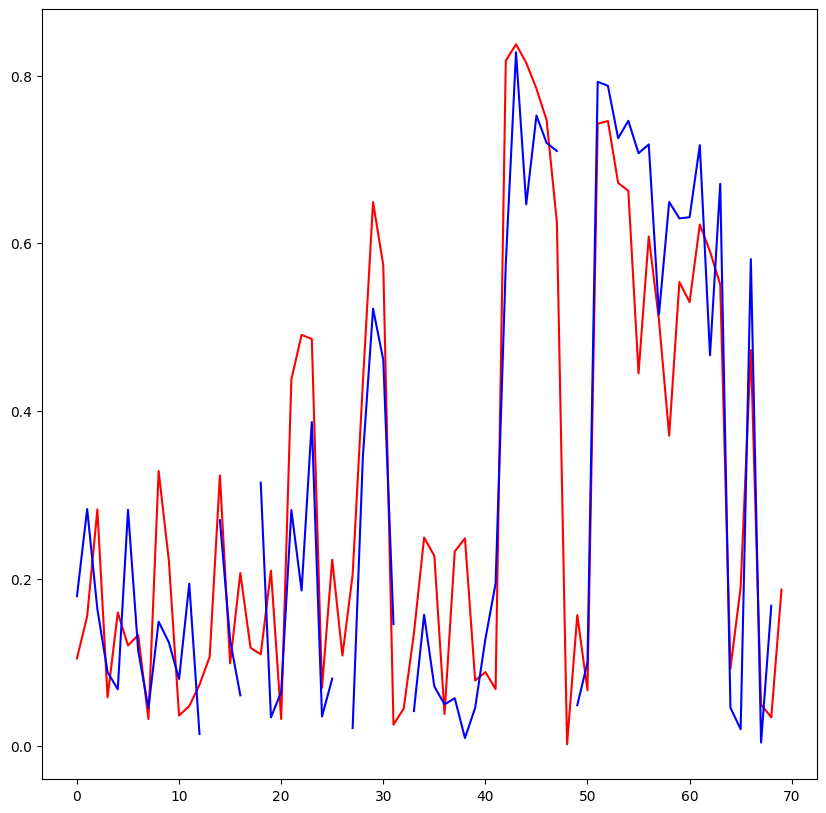

In [91]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(interpolate_(features_.iloc[2], f, save_values=False).values, c='red')
ax.plot(features_.iloc[2].values, c='blue')

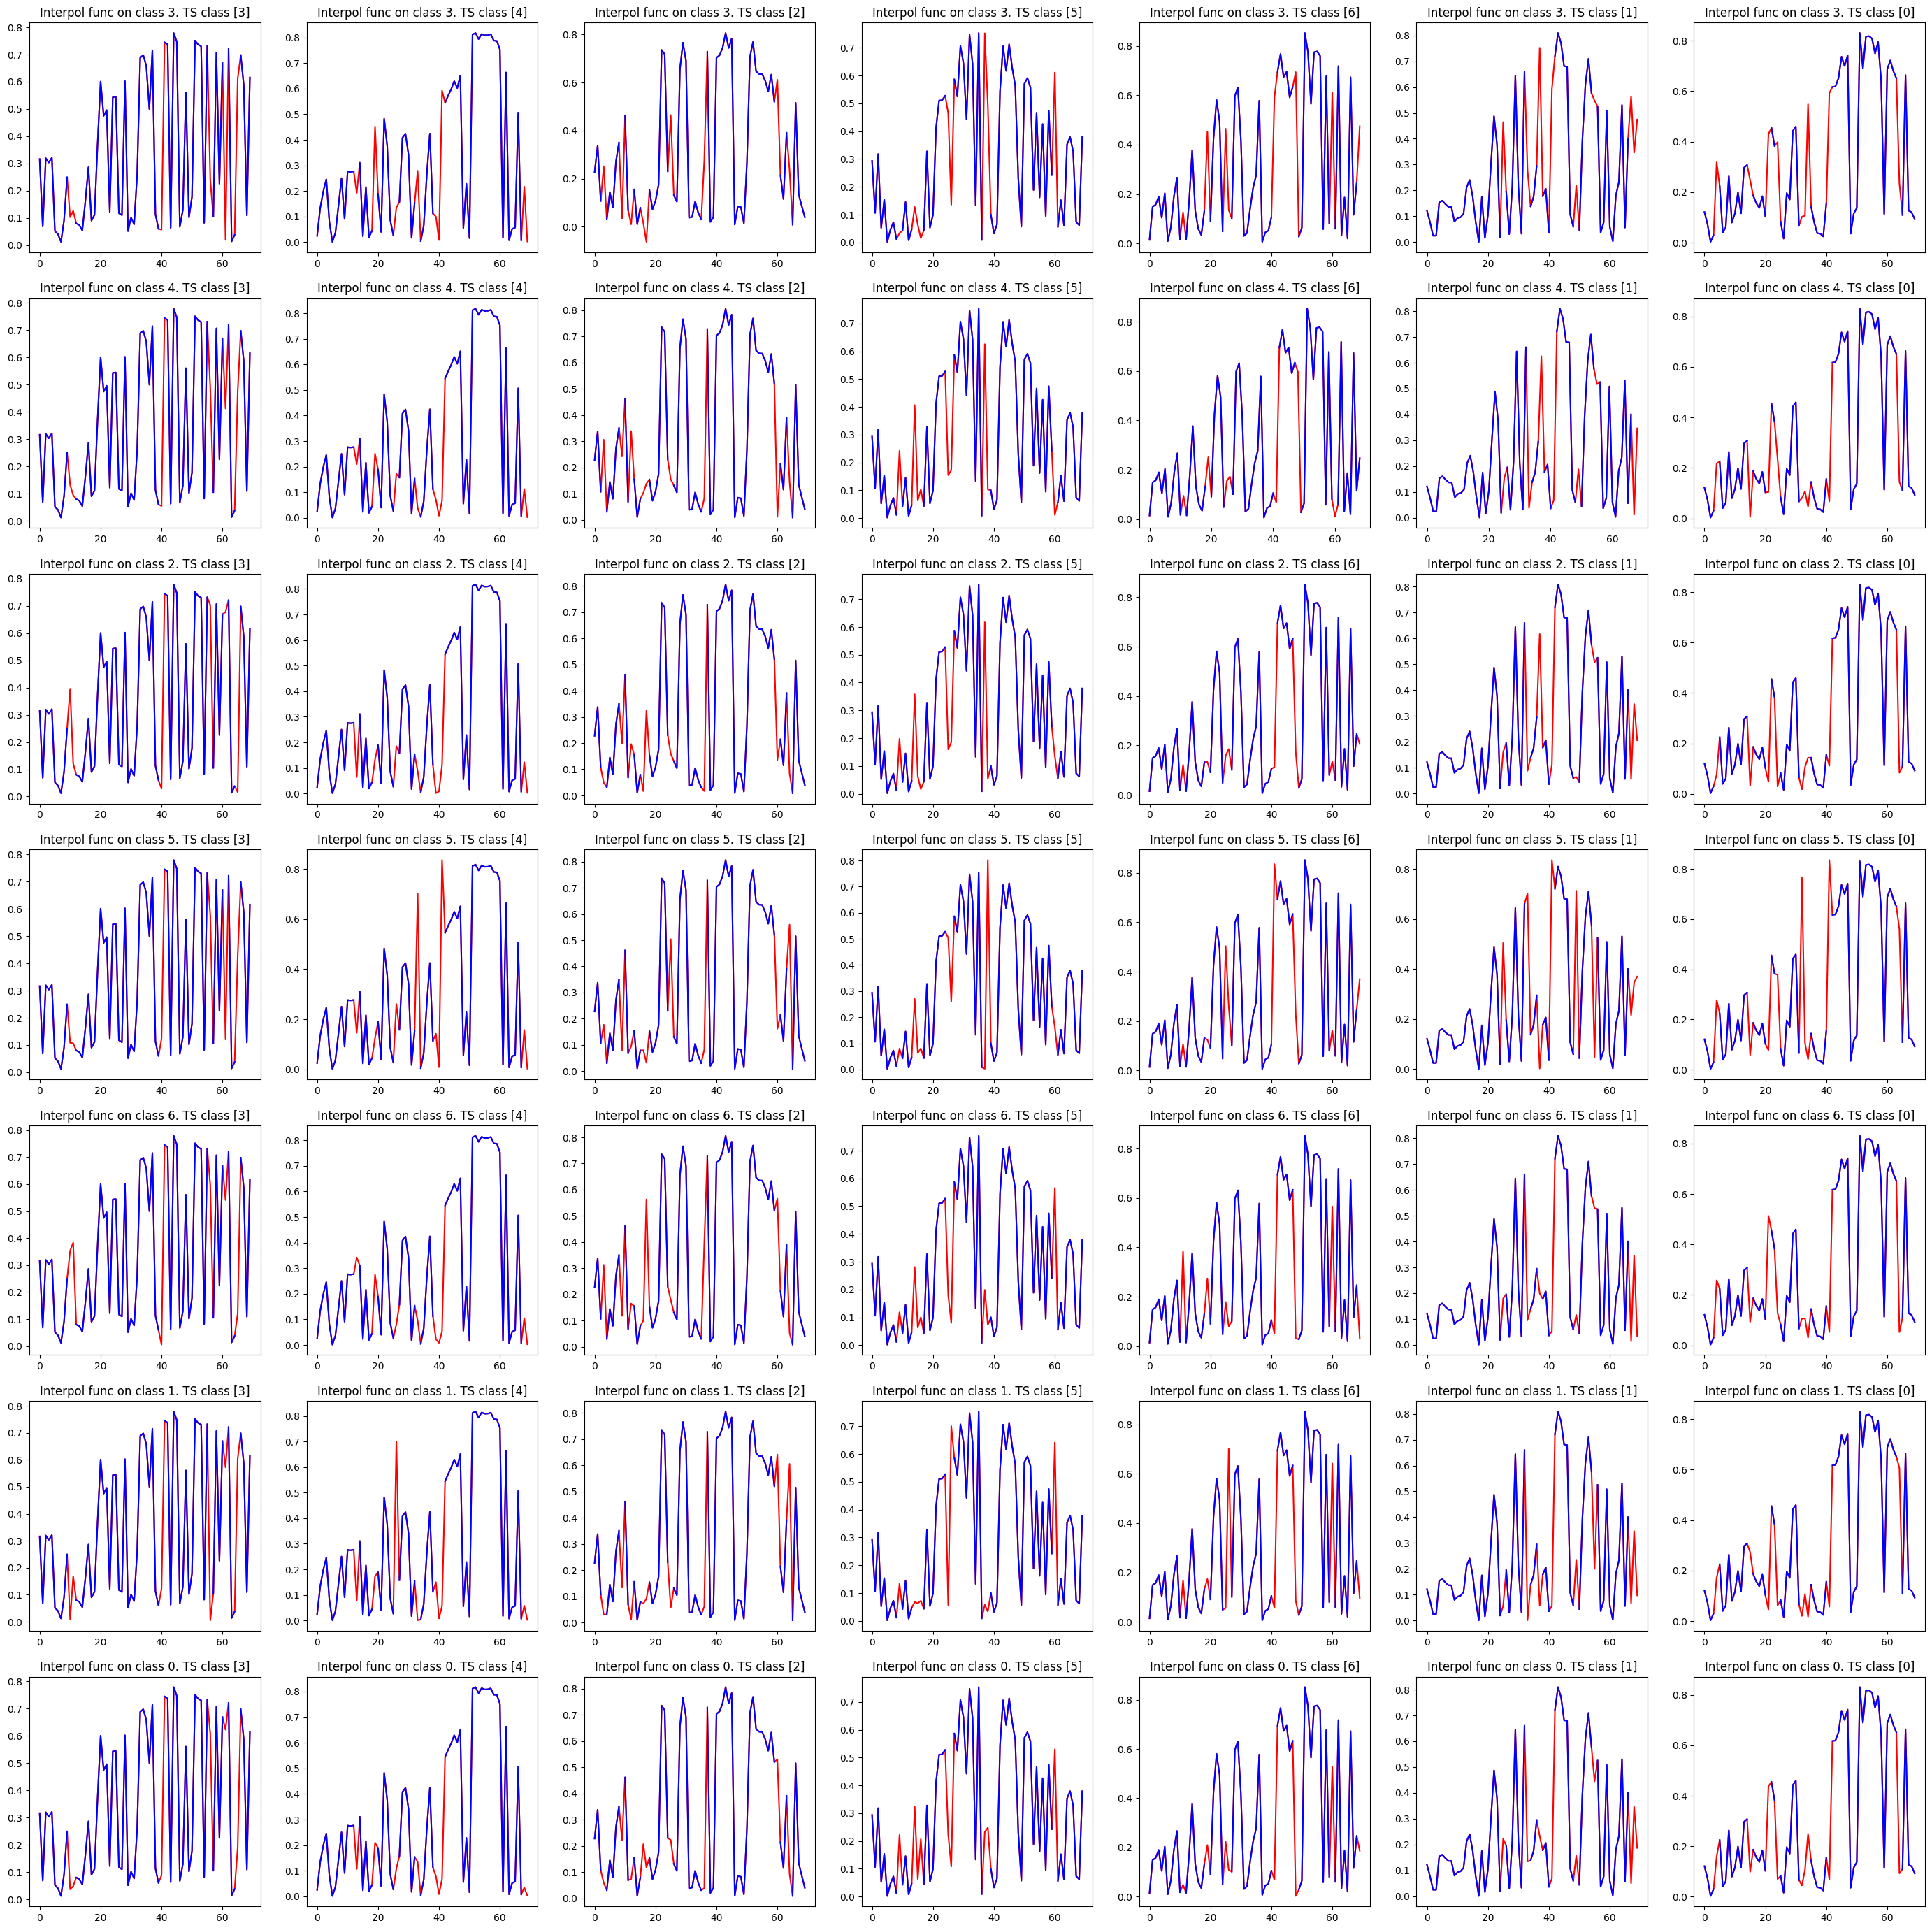

In [122]:
classes = pd.unique(target.crop)
n_classes = classes.shape[0]
fig, axes = plt.subplots(n_classes, n_classes, figsize=(5*n_classes, 5*n_classes))

subset = pd.DataFrame()
for class_ in classes:
    features_ = features.loc[target.index[(target == class_).values.ravel()].tolist(), ts_cols]
    mode = stats.mode(features_.isna().sum(axis=1))[0]
    average_ts = features_[features_.isna().sum(axis=1) == mode[0]].iloc[0]
    subset[average_ts.name] = average_ts
subset = subset.T

for i, class_ in enumerate(classes):
    features_ = features.loc[target.index[(target == class_).values.ravel()].tolist(), ts_cols]
    best_ts = features_.isna().sum(axis=1).argmin()
    func = get_interpolate_f(features_.iloc[best_ts])
    
    for j, (_, row) in enumerate(subset.iterrows()):
        axes[i,j].plot(interpolate_(row, func, save_values=True).values, c='red')
        axes[i,j].plot(row.values, c='blue')
        
        axes[i,j].set_title(f'Interpol func on class {class_}. TS class {target.loc[row.name].values}')

In [73]:
train_file = 'data/train_dataset_train.csv'
test_file = 'data/test_dataset_test.csv'

data = pd.read_csv(train_file)
data.sort_index(axis=1, inplace=True)
data.set_index('id', inplace=True)

target_col = pd.Index(['crop'])
area_col = pd.Index(['area'])
geo_col = pd.Index(['.geo'])
ts_cols = data.columns.difference(area_col.append([geo_col, target_col])).to_list()

data = rename_cols(data)

In [104]:
first_date = dt.strptime("2021-04-15", "%Y-%m-%d")
last_date = dt.strptime("2021-08-27", "%Y-%m-%d")
n_days = (last_date - first_date).days + 1

all_dates = np.array(range(1, n_days + 1))
existed_dates = np.array(ts_cols)
new_dates = np.setdiff1d(all_dates, existed_dates)

def rename_cols(df):
    global ts_cols
    new_names = {old_name: (dt.strptime(old_name.split('_')[-1], "%Y-%m-%d") - first_date).days+1 for old_name in ts_cols}
    df = df.rename(new_names, axis=1)

    ts_cols = df.columns.difference(area_col.append([geo_col, target_col])).to_list()
    return df

def expand_dates(row):
    new_row = pd.Series(index = all_dates, dtype=np.float64, name=row.name)
    new_row[existed_dates] = row[existed_dates].copy()
    new_row[new_dates] = np.zeros(new_dates.shape[0])
    new_row = new_row.astype(np.float32)
    
    return new_row

In [192]:
from scipy.optimize import leastsq
from scipy.special import erf
   
def BISE(row, window_s=28):
    # expanded_row = expand_dates(row)
    
    reconstructed = pd.Series(index=row.index, dtype=np.float64, name=row.name)
    prev_p = -1
    rejected_days = []
    accepted_days = []
    
    for i in reconstructed.index:
        curr_p = row[i]
        
        if curr_p >= prev_p:
            reconstructed[i] = curr_p
            prev_p = curr_p
            accepted_days.append(i)
        elif curr_p == 0:
            rejected_days.append(i)
        else:
            diff = prev_p - curr_p
            
            start = max(1, i - window_s +1)
            end = min(i, window_s) + start
            window = np.intersect1d(np.array(range(start, end)), accepted_days)
                   
            if reconstructed.loc[window.tolist()].max() * 0.8 < diff:
                reconstructed[i] = curr_p
                prev_p = curr_p
                accepted_days.append(i)
            else:
                rejected_days.append(i)
                
    func = interpolate.interp1d(accepted_days, reconstructed[accepted_days], fill_value=0, bounds_error=False)
    reconstructed[rejected_days] = func(rejected_days)
    
    return reconstructed

def asymGaussian(row):
    def asymGaussian_(x, p):
        amp = (p[0] / (p[2] * np.sqrt(2 * np.pi)))
        spread = np.exp((-(x - p[1]) ** 2.0) / (2 * p[2] ** 2.0))
        skew = (1 + erf((p[3] * (x - p[1])) / (p[2] * np.sqrt(2))))
        return amp * spread * skew
    
    def residuals(p,y,x):
        return y - asymGaussian_(x, p)
    
    initials = [6.5, 13, 1, 0]
    
    y = row.values
    x = np.array(row.index)
    
    cnsts = leastsq(residuals, initials, args=(y, x))[0]
    
    return pd.Series(asymGaussian_(x, cnsts), index=row.index)

Text(0.5, 1.0, 'NDVI для первого объектат (с интерполяцией BISE)')

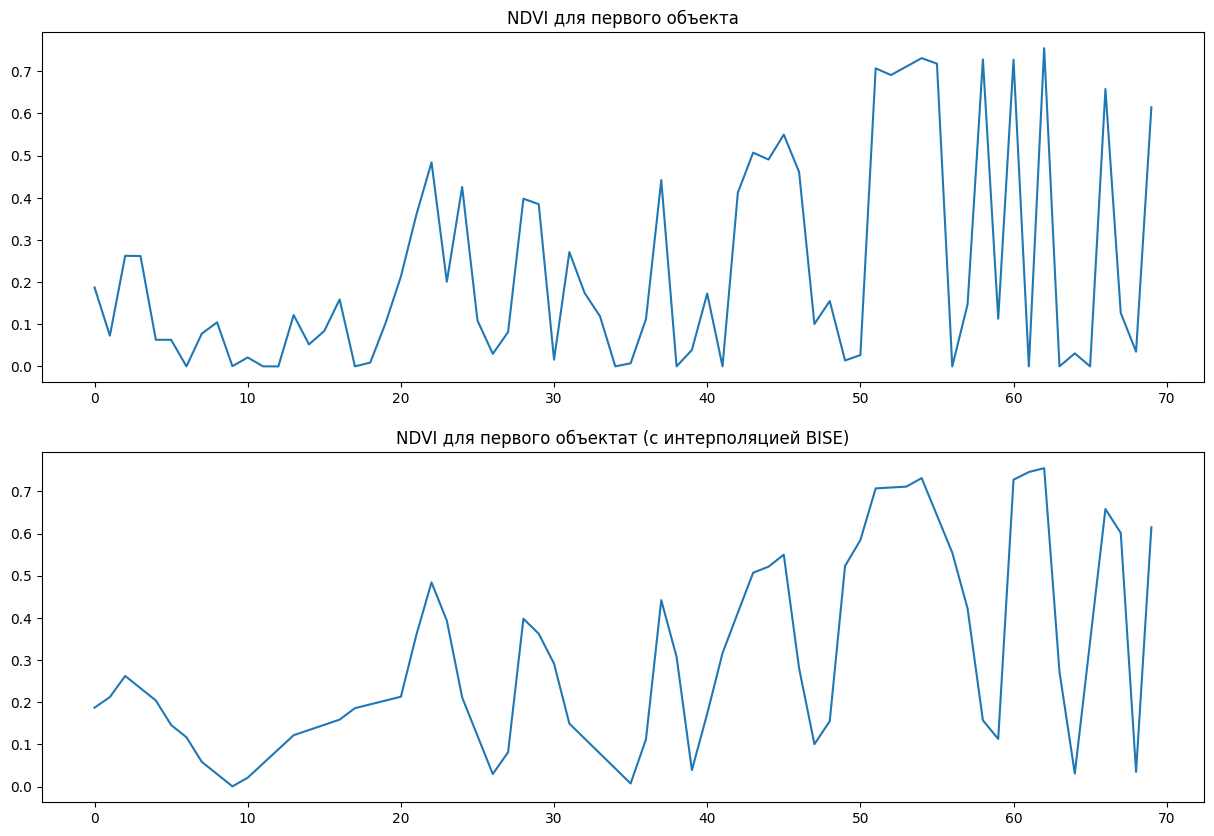

In [190]:
fig, axes = plt.subplots(2,1,figsize=(15,10))

axes[0].plot(data.iloc[0][ts_cols].values)
axes[1].plot(BISE(data[ts_cols].iloc[0]).values)

axes[0].set_title('NDVI для первого объекта')
axes[1].set_title('NDVI для первого объектат (с интерполяцией BISE)')

TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

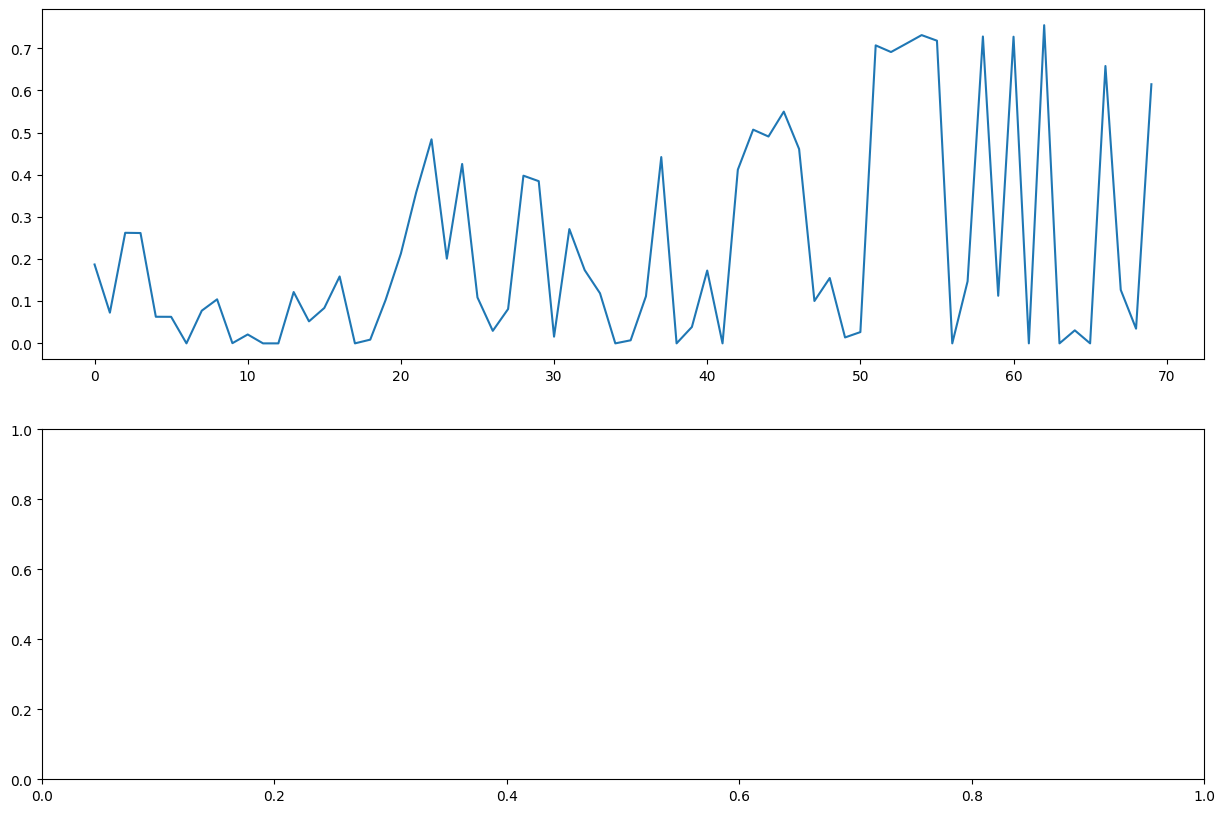

In [193]:
fig, axes = plt.subplots(2,1,figsize=(15,10))

axes[0].plot(data.iloc[0][ts_cols].values)
axes[1].plot(asymGaussian(data[ts_cols].iloc[0]).values)

axes[0].set_title('NDVI для первого объекта')
axes[1].set_title('NDVI для первого объектат (с интерполяцией asymGaussian)')